# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Standard library
from pathlib import Path
import pprint

# Third-party libraries
import duckdb
import fireducks.pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna

# Custom osbad library for anomaly detection
import osbad.config as bconf
import osbad.hyperparam as hp
import osbad.modval as modval
import osbad.viz as bviz
from osbad.database import BenchDB
from osbad.scaler import CycleScaling
from osbad.model import ModelRunner

# Import dataset

## Define filepath here

In [2]:
# Path to database directory
DB_DIR = bconf.DB_DIR

db_filepath = DB_DIR.joinpath("train_dataset_severson.db")

## Get the cell inventory of the training dataset

In [3]:
# Create a DuckDB connection
con = duckdb.connect(
    db_filepath,
    read_only=True)

# Load all training dataset from duckdb
df_duckdb = con.execute(
    "SELECT * FROM df_train_dataset_sv").fetchdf()

# Get the cell index of training dataset
unique_cell_index_train = df_duckdb["cell_index"].unique()
print(f"Unique cell index: {unique_cell_index_train}")

Unique cell index: ['2017-05-12_5_4C-50per_3C_CH13' '2017-05-12_5_4C-50per_3C_CH14'
 '2017-05-12_5_4C-60per_3C_CH15' '2017-05-12_5_4C-60per_3C_CH16'
 '2017-05-12_5_4C-70per_3C_CH17' '2017-05-12_5_4C-70per_3C_CH18'
 '2017-05-12_6C-40per_3C_CH25' '2017-05-12_6C-40per_3C_CH26'
 '2017-05-12_6C-50per_3C_CH27' '2017-05-12_6C-50per_3C_CH28'
 '2017-05-12_6C-60per_3C_CH29' '2017-05-12_6C-60per_3C_CH30'
 '2017-05-12_7C-40per_3C_CH37' '2017-05-12_7C-40per_3C_CH38'
 '2017-05-12_4C-80per_4C_CH5' '2017-05-12_4C-80per_4C_CH6'
 '2017-05-12_4_4C-80per_4_4C_CH7' '2017-05-12_5_4C-80per_5_4C_CH11'
 '2017-05-12_5_4C-80per_5_4C_CH12' '2017-05-12_3_6C-80per_3_6C_CH1'
 '2017-05-12_3_6C-80per_3_6C_CH2' '2017-05-12_3_6C-80per_3_6C_CH3'
 '2017-05-12_5_4C-40per_3_6C_CH19']


## Filtered dataset for selected cell only

In [4]:
# Get the cell-ID from cell_inventory
selected_cell_label = "2017-05-12_5_4C-70per_3C_CH17"

# Create a subfolder to store fig output
# corresponding to each cell-index
selected_cell_artifacts_dir = bconf.artifacts_output_dir(
    selected_cell_label)

In [5]:
# Filter dataset for specific selected cell only
df_selected_cell = df_duckdb[
    df_duckdb["cell_index"] == selected_cell_label]

# Anomalous cycle has label = 1
# Normal cycle has label = 0
# true outliers from benchmarking dataset
df_true_outlier = df_selected_cell[
    df_selected_cell["outlier"] == 1]

# Get the cycle index of anomalous cycle
# To create plot legend
true_outlier_cycle_index = (
    df_true_outlier["cycle_index"].unique())
true_outlier_cycle_index

array([  0.,  40., 147., 148.])

## Drop true labels

* Drop true outlier labels (denoted as ``outlier``) from the dataframe and select only relevant features for ML:
  * ``cell_index``: The cell-ID for data and model versioning purposes;
  * ``cycle_index``: The cycle number of each cell;
  * ``discharge_capacity``: Discharge capacity of the cell;
  * ``voltage``: Discharge voltage of the cell.

In [6]:
# Import the BenchDB class
# Load only the dataset based on the selected cell
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

# load the benchmarking dataset
df_selected_cell = benchdb.load_benchmark_dataset(
    dataset_type="train")

if df_selected_cell is not None:

    filter_col = [
        "cell_index",
        "cycle_index",
        "discharge_capacity",
        "voltage"]

    # Drop true labels from the benchmarking dataset
    # and filter for selected columns only
    df_selected_cell_without_labels = benchdb.drop_labels(
        df_selected_cell,
        filter_col)

    # print a subset of the dataframe
    # for diagnostics running in terminals
    print(df_selected_cell_without_labels.head(10).to_markdown())
    print("*"*100)

    # Extract true outliers cycle index from benchmarking dataset
    true_outlier_cycle_index = benchdb.get_true_outlier_cycle_index(
        df_selected_cell)
    print(f"True outlier cycle index:")
    print(true_outlier_cycle_index)

Database is found in the given filepath.
Loading benchmarking dataset now...
****************************************************************************************************
|    | cell_index                    |   cycle_index |   discharge_capacity |   voltage |
|---:|:------------------------------|--------------:|---------------------:|----------:|
|  0 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          1.26512e-05 |   3.29189 |
|  1 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00136774  |   3.28185 |
|  2 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00292998  |   3.27788 |
|  3 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  4 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  5 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00605927  |   3.27299 |
|  6 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00762155  |   3.27124 |
|  7 | 2017-

## Plot cycling data with true labels

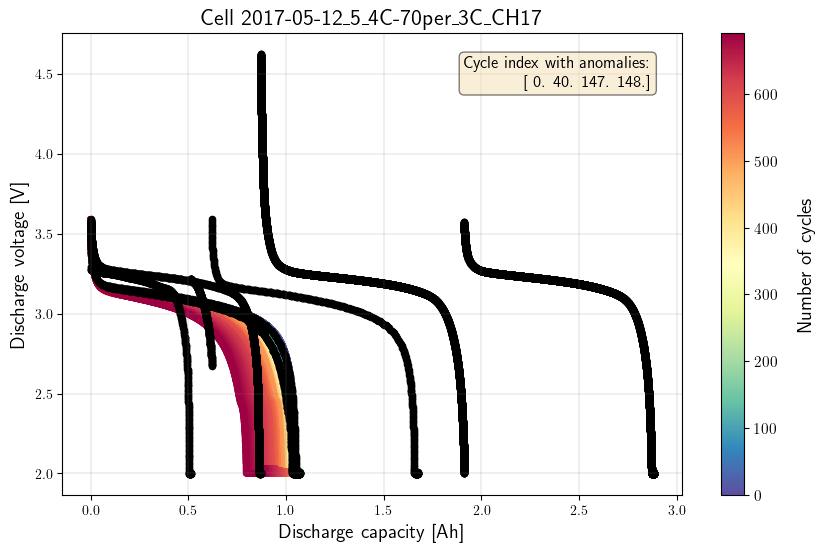

In [7]:
# Plot cell data with true anomalies
# If the true outlier cycle index is not known,
# cycling data will be plotted without labels
benchdb.plot_cycle_data(
    df_selected_cell_without_labels,
    true_outlier_cycle_index)

plt.show()

# Statistical Feature Transformation

To help with the separation of abnormal cycles from normal cycles, we propose a new statistical feature transformation method using the median and IQR of the input features:  

$$
\begin{equation}
x_\textrm{scaled} = x_i - \left[\frac{\textrm{median}(X)^{2}}{\textrm{IQR}(X)}\right],
\end{equation} 
$$

where the IQR can be calculated from the third ($75^\textrm{th}$ percentile) and first quartile ($25^\textrm{th}$ percentile) of the input vector ($\textrm{IQR}(X) = Q_3(X) - Q_1(X)$). Here, we use $\textrm{median}(X)^2$ to preserve the physical unit of the original feature after feature transformation. Feature scaling is implemented on both the capacity and voltage data.

## Capacity scaling

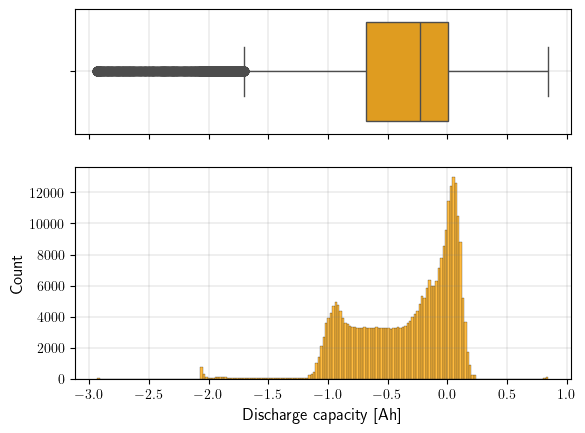

count    313326.000000
mean         -0.349626
std           0.414280
min          -2.933561
25%          -0.677412
50%          -0.226724
75%           0.005721
max           0.844670
Name: scaled_discharge_capacity, dtype: float64
**********************************************************************


0        -0.828787
1        -0.827432
2        -0.825870
3        -0.824306
4        -0.824306
            ...   
301553   -0.145985
301554   -0.145915
301555   -0.145915
301556   -0.145867
301557   -0.145867
Name: scaled_discharge_capacity, Length: 313326, dtype: float64

In [8]:
# Instantiate the CycleScaling class
scaler = CycleScaling(
    df_selected_cell=df_selected_cell_without_labels)

# Implement median IQR scaling on the discharge capacity data
df_capacity_med_scaled = scaler.median_IQR_scaling(
    variable="discharge_capacity",
    validate=True)

# Plot the histogram and boxplot of the scaled data
ax_hist = bviz.hist_boxplot(
    df_variable=df_capacity_med_scaled["scaled_discharge_capacity"])

ax_hist.set_xlabel(
    r"Discharge capacity [Ah]",
    fontsize=12)
ax_hist.set_ylabel(
    r"Count",
    fontsize=12)

output_fig_filename = (
    "cap_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Print the summary statistics of the scaled capacity data
print(df_capacity_med_scaled["scaled_discharge_capacity"].describe())
print("*"*70)

df_capacity_med_scaled["scaled_discharge_capacity"]

## Voltage scaling

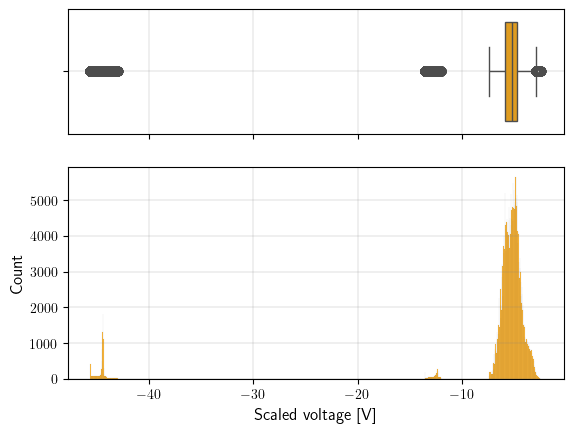

count    313326.000000
mean         -6.557421
std           7.159671
min         -45.644671
25%          -5.844655
50%          -5.215267
75%          -4.672330
max          -2.395836
Name: scaled_voltage, dtype: float64
**********************************************************************


0        -12.262836
1        -12.272870
2        -12.276842
3        -12.279593
4        -12.279593
            ...    
301553    -4.257652
301554    -4.257553
301555    -4.257553
301556    -4.257912
301557    -4.254364
Name: scaled_voltage, Length: 313326, dtype: float64

In [9]:
# Implement median IQR scaling on the discharge voltage data
df_voltage_med_scaled = scaler.median_IQR_scaling(
    variable="voltage",
    validate=True)

# Plot the histogram and boxplot of the scaled data
ax_hist = bviz.hist_boxplot(
    df_variable=df_voltage_med_scaled["scaled_voltage"])

ax_hist.set_xlabel(
    r"Scaled voltage [V]",
    fontsize=12)
ax_hist.set_ylabel(
    r"Count",
    fontsize=12)

output_fig_filename = (
    "voltage_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Print the summary statistics of the scaled capacity data
print(df_voltage_med_scaled["scaled_voltage"].describe())
print("*"*70)
df_voltage_med_scaled["scaled_voltage"]

## Scatter histogram

* Create scatterplot with histogram to display the distribution for x-axis and y-axis:
  * The salmon color corresponds to x-axis (``scaled_capacity``)
  * The grey color corresponds to y-axis (``scaled_voltage``)

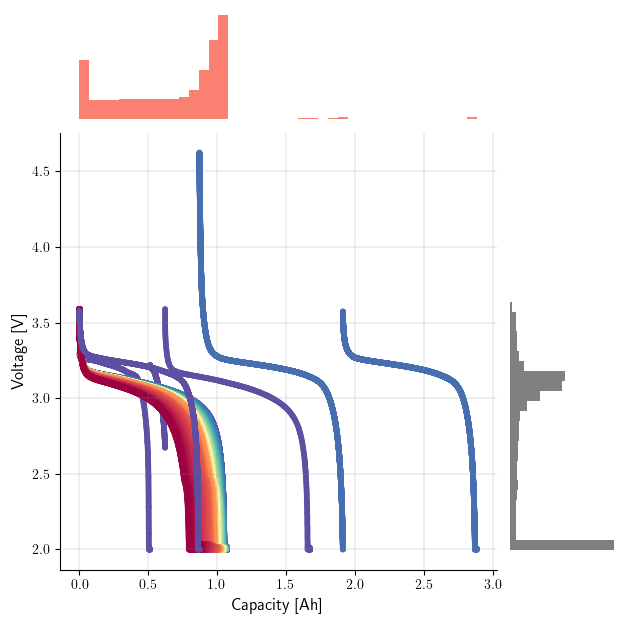

In [10]:
axplot = bviz.scatterhist(
    xseries=df_selected_cell_without_labels["discharge_capacity"],
    yseries=df_selected_cell_without_labels["voltage"],
    cycle_index_series=df_selected_cell_without_labels["cycle_index"])

axplot.set_xlabel(
    r"Capacity [Ah]",
    fontsize=12)
axplot.set_ylabel(
    r"Voltage [V]",
    fontsize=12)

output_fig_filename = (
    "scatterhist_no_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

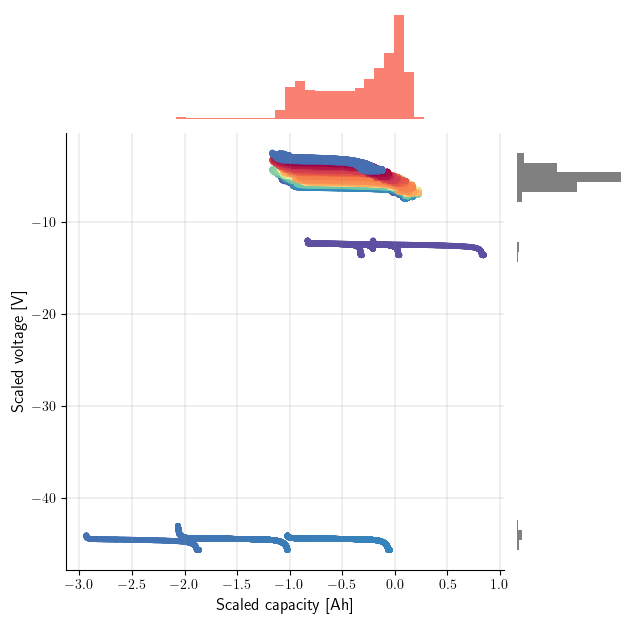

In [11]:
axplot = bviz.scatterhist(
    xseries=df_capacity_med_scaled["scaled_discharge_capacity"],
    yseries=df_voltage_med_scaled["scaled_voltage"],
    cycle_index_series=df_selected_cell_without_labels["cycle_index"])

axplot.set_xlabel(
    r"Scaled capacity [Ah]",
    fontsize=12)
axplot.set_ylabel(
    r"Scaled voltage [V]",
    fontsize=12)

output_fig_filename = (
    "scatterhist_with_scaling_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# Physics-informed Feature Extraction

* As the anomalies in this dataset are collective due to a continuous series of abnormal voltage and current measurements, we can transform the collective anomalies of a given cycle into cycle-wise point anomalies.
* If continuous abnormal voltage and current measurements are recorded in a cycle, the specific cycle will be labelled as anomalous cycle.

$$
\begin{align}
\Delta Q_\textrm{scaled,max,cyc} &= \underset{\textrm{cyc}}{\max}(Q_{\textrm{scaled},{k+1}} - Q_{\textrm{scaled},{k}}), \\
\Delta V_\textrm{scaled,max,cyc} &= \underset{\textrm{cyc}}{\max}(V_{\textrm{scaled},{k+1}} - V_{\textrm{scaled},{k}}),
\end{align} 
$$

where $\Delta V_\textrm{scaled,max,cyc}$ is the maximum scaled voltage difference per cycle and $\Delta Q_\textrm{scaled,max,cyc}$ is the maximum scaled capacity difference per cycle. $k$ in these equations denote the index of each recorded data point. 

## Feature max dQ

In [12]:
# maximum scaled capacity difference per cycle
df_max_dQ = scaler.calculate_max_diff_per_cycle(
    df_scaled=df_capacity_med_scaled,
    variable_name="scaled_discharge_capacity")

# Don't use the natural index of the 
# dataframe as the cycle index
# Create an additional column for the cycle_index
# so that we can keep track of the true cycle_index 
# even after removing some anomalous cycle from the df

# Update the column name to include dQ into the name
# so that when the features are merged together later
# we can track the origins of the feature
df_max_dQ.columns = [
    "max_diff_dQ",
    "log_max_diff_dQ",
    "cycle_index"]

df_max_dQ

,max_diff_dQ,log_max_diff_dQ,cycle_index
0,0.006388,-5.053343,0.0
1,0.006338,-5.061258,1.0
2,0.006321,-5.063922,2.0
3,0.006259,-5.073756,3.0
4,0.006236,-5.077346,4.0
...,...,...,...
687,0.006236,-5.077391,687.0
688,0.006281,-5.070178,688.0
689,0.006243,-5.076238,689.0
690,0.006316,-5.064619,690.0


## Feature max dV

In [13]:
# maximum scaled voltage difference per cycle
df_max_dV = scaler.calculate_max_diff_per_cycle(
    df_scaled=df_voltage_med_scaled,
    variable_name="scaled_voltage")

# Update the column name to include dV into the name
# so that when the features are merged together later
# we can track the origins of the feature
# The cycle index remains the same for both 
# dV and dQ features
df_max_dV.columns = [
    "max_diff_dV",
    "log_max_diff_dV",
    "cycle_index"]

df_max_dV

,max_diff_dV,log_max_diff_dV,cycle_index
0,1.564151,0.447343,0.0
1,0.023727,-3.741163,1.0
2,0.022684,-3.786091,2.0
3,0.027899,-3.579172,3.0
4,0.026408,-3.634081,4.0
...,...,...,...
687,0.046420,-3.070023,687.0
688,0.051542,-2.965352,688.0
689,0.047776,-3.041228,689.0
690,0.046331,-3.071935,690.0


## Bubble plot

In [14]:
# Calculate the bubble size ratio for plotting
df_bubble_size_dQ = bviz.calculate_bubble_size_ratio(
    df_variable=df_max_dQ["max_diff_dQ"])

df_bubble_size_dV = bviz.calculate_bubble_size_ratio(
    df_variable=df_max_dV["max_diff_dV"])

Feature mean: 0.00641125672398844
Feature max: 0.042899057000000074
Feature min: 0.006194469999999952
Feature std: 0.0019646872892444154
**********************************************************************
Feature mean: 0.04105323627167629
Feature max: 2.612268400000005
Feature min: 0.022684100000000207
Feature std: 0.11397361246602544
**********************************************************************


## Merge features

In [15]:
# Merge both df_max_dV, df_max_dQ into a df
# Remove the duplicated cycle_index column
df_merge = pd.concat([df_max_dV, df_max_dQ], axis=1)
df_merge_features = df_merge.loc[
    :, ~df_merge.columns.duplicated()].copy()

df_merge_features

,max_diff_dV,log_max_diff_dV,cycle_index,max_diff_dQ,log_max_diff_dQ
0,1.564151,0.447343,0.0,0.006388,-5.053343
1,0.023727,-3.741163,1.0,0.006338,-5.061258
2,0.022684,-3.786091,2.0,0.006321,-5.063922
3,0.027899,-3.579172,3.0,0.006259,-5.073756
4,0.026408,-3.634081,4.0,0.006236,-5.077346
...,...,...,...,...,...
687,0.046420,-3.070023,687.0,0.006236,-5.077391
688,0.051542,-2.965352,688.0,0.006281,-5.070178
689,0.047776,-3.041228,689.0,0.006243,-5.076238
690,0.046331,-3.071935,690.0,0.006316,-5.064619


## Bubble plot without log transformation

Potential anomalous cycle: 0.0
x-position of the text: 0.006387939999999981
y-position of the text: 1.5641508000000002
----------------------------------------------------------------------
Potential anomalous cycle: 40.0
x-position of the text: 0.006304919999999825
y-position of the text: 2.612268400000005
----------------------------------------------------------------------
Potential anomalous cycle: 147.0
x-position of the text: 0.04281378999999996
y-position of the text: 0.029431299999999716
----------------------------------------------------------------------
Potential anomalous cycle: 148.0
x-position of the text: 0.042899057000000074
y-position of the text: 0.02523799999999987
----------------------------------------------------------------------


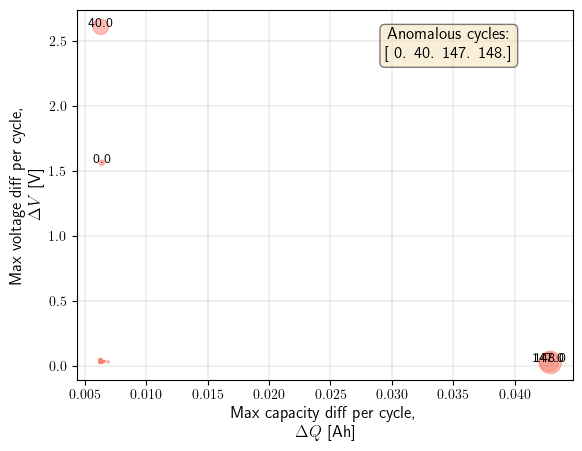

In [16]:
# Get the cycle count to label the bubbles
unique_cycle_count = (df_selected_cell_without_labels["cycle_index"]
    .unique())

# bubble size for multivariate anomalies
bubble_size = (
    np.abs(df_bubble_size_dV)
    * np.abs(df_bubble_size_dQ))

# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=df_merge_features["max_diff_dQ"],
    yseries=df_merge_features["max_diff_dV"],
    bubble_size=bubble_size,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=true_outlier_cycle_index)

axplot.set_xlabel(
    r"Max capacity diff per cycle," 
    + "\n" 
    + "$\Delta Q$ [Ah]",
    fontsize=12)

axplot.set_ylabel(
    r"Max voltage diff per cycle," 
    + "\n" 
    + "$\Delta V$ [V]",
    fontsize=12)

plt.show()

## Bubble plot with log transformation

* Log transformation helps to further separate data points that closely clustered together.

Potential anomalous cycle: 0.0
x-position of the text: -5.053343441284631
y-position of the text: 0.44734305691240445
----------------------------------------------------------------------
Potential anomalous cycle: 40.0
x-position of the text: -5.066424997988364
y-position of the text: 0.9602189626435208
----------------------------------------------------------------------
Potential anomalous cycle: 147.0
x-position of the text: -3.1508950320267735
y-position of the text: -3.5256965450993665
----------------------------------------------------------------------
Potential anomalous cycle: 148.0
x-position of the text: -3.1489054346417387
y-position of the text: -3.6794044837514233
----------------------------------------------------------------------


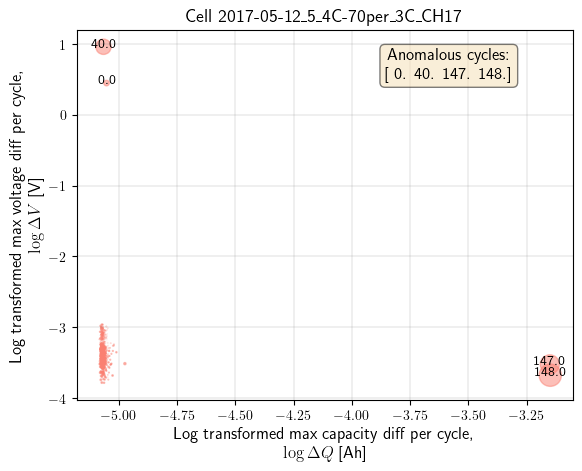

In [17]:
# Plot the bubble chart and label the outliers
axplot = bviz.plot_bubble_chart(
    xseries=df_merge_features["log_max_diff_dQ"],
    yseries=df_merge_features["log_max_diff_dV"],
    bubble_size=bubble_size,
    unique_cycle_count=unique_cycle_count,
    cycle_outlier_idx_label=true_outlier_cycle_index)

axplot.set_title(
    f"Cell {selected_cell_label}", fontsize=13)

axplot.set_xlabel(
    r"Log transformed max capacity diff per cycle," 
    + "\n" 
    + r"$\log\Delta Q$ [Ah]",
    fontsize=12)

axplot.set_ylabel(
    r"Log transformed max voltage diff per cycle," 
    + "\n" 
    r"$\log\Delta V$ [V]",
    fontsize=12)

output_fig_filename = (
    "multivariate_bubble_plot_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

# K Nearest Neighbors (KNN) without hyperparameter tuning

## Instantiate ModelRunner for knn

In [18]:
selected_feature_cols = (
    "log_max_diff_dQ",
    "log_max_diff_dV")

# Instantiate ModelRunner with selected features and cell_label
runner = ModelRunner(
    cell_label=selected_cell_label,
    df_input_features=df_merge_features,
    selected_feature_cols=selected_feature_cols
)

## Create Xdata for training

In [19]:
# create Xdata array
Xdata = runner.create_model_x_input()

## Fit the model

In [20]:
cfg = hp.MODEL_CONFIG["knn"]

# create model instance without hyperparameter tuning
model = cfg.baseline_model_param()
model.fit(Xdata)

# Predict probabilistic outlier score
proba = model.predict_proba(Xdata)

# Get predicted outlier cycle and score from 
# the probabilistic outlier score
(pred_outlier_indices,
 pred_outlier_score) = runner.pred_outlier_indices_from_proba(
    proba=proba,
    threshold=0.7,
    outlier_col=cfg.proba_col
)

print("Predicted anomalous cycles:")
print(pred_outlier_indices)
print("-"*70)
print("Predicted corresponding outlier score:")
print(pred_outlier_score)

Predicted anomalous cycles:
[ 0 40]
----------------------------------------------------------------------
Predicted corresponding outlier score:
[0.86790029 0.99774558]


In [21]:
# Access the default hyperparameters without tuning
baseline_model_param = model.get_params()
pprint.pp(baseline_model_param)

{'algorithm': 'auto',
 'contamination': 0.1,
 'leaf_size': 30,
 'method': 'largest',
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 5,
 'p': 2,
 'radius': 1.0}


# Probabilistic outliers prediction

## Predict anomalous cycles

In [22]:
df_outliers_pred = df_merge_features[
    df_merge_features["cycle_index"]
    .isin(pred_outlier_indices)].copy()

df_outliers_pred["outlier_prob"] = pred_outlier_score
df_outliers_pred

,max_diff_dV,log_max_diff_dV,cycle_index,max_diff_dQ,log_max_diff_dQ,outlier_prob
0,1.564151,0.447343,0.0,0.006388,-5.053343,0.867900
40,2.612268,0.960219,40.0,0.006305,-5.066425,0.997746


## Probabilistic anomaly score map

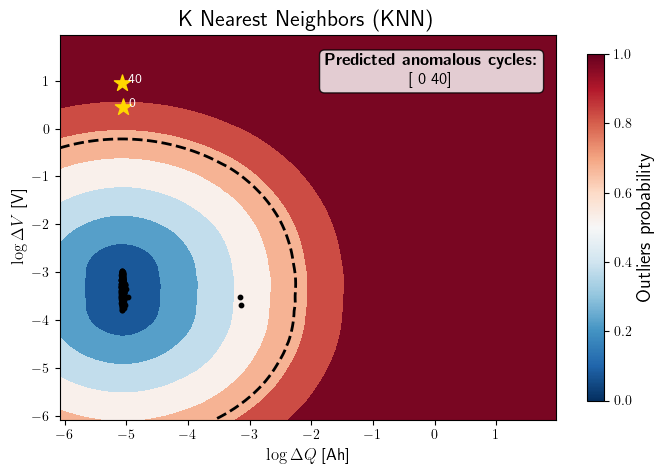

In [23]:
axplot = runner.predict_anomaly_score_map(
    selected_model=model,
    model_name="K Nearest Neighbors (KNN)",
    xoutliers=df_outliers_pred["log_max_diff_dQ"],
    youtliers=df_outliers_pred["log_max_diff_dV"],
    pred_outliers_index=pred_outlier_indices,
    threshold=0.7
)

axplot.set_xlabel(
    r"$\log\Delta Q$ [Ah]",
    fontsize=12)
axplot.set_ylabel(
    r"$\log\Delta V$ [V]",
    fontsize=12)

output_fig_filename = (
    "isolation_forest_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Histogram of the anomaly score

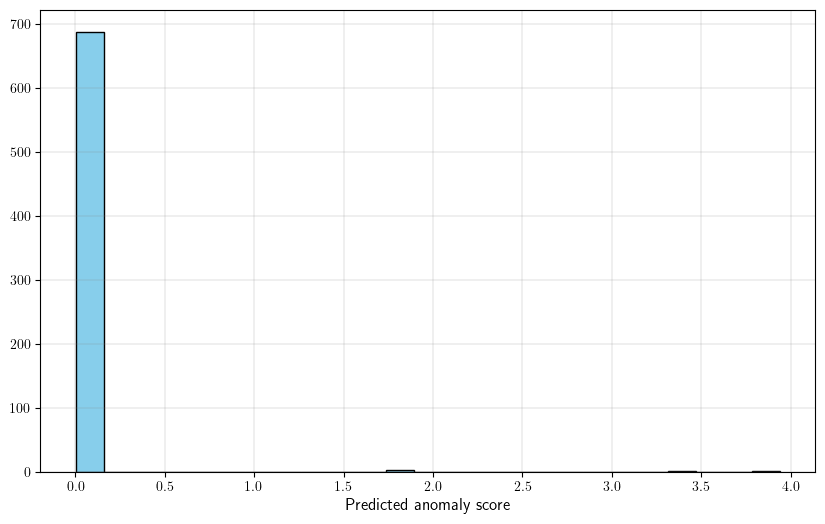

In [24]:
outlier_score = model.decision_function(Xdata)

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(
    outlier_score,
    color="skyblue",
    edgecolor="black",
    bins=25)

ax.set_xlabel(
    "Predicted anomaly score",
    fontsize=12)

ax.grid(
    color="grey",
    linestyle="-",
    linewidth=0.25,
    alpha=0.7)

plt.show()

In [25]:
# threshold without hyperparameter tuning
model.threshold_

np.float64(0.014467039593519639)

# Model performance evaluation

In [26]:
# Compare predicted probabilistic outliers against true outliers 
# from the benchamrking dataset
df_eval_outlier = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=pred_outlier_indices)
df_eval_outlier

,cycle_index,true_outlier,pred_outlier
0,0.0,1,1
1,1.0,0,0
2,2.0,0,0
3,3.0,0,0
4,4.0,0,0
...,...,...,...
687,687.0,0,0
688,688.0,0,0
689,689.0,0,0
690,690.0,0,0


## Confusion matrix

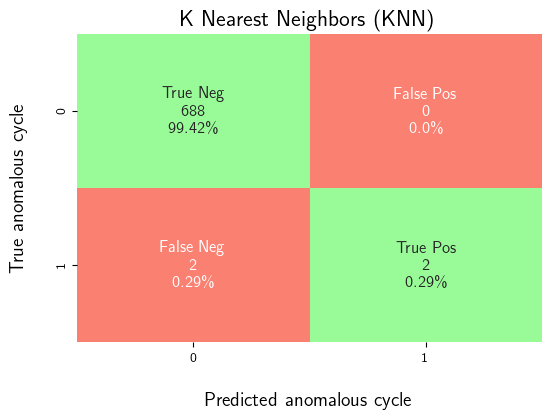

In [27]:
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier["true_outlier"],
    y_pred=df_eval_outlier["pred_outlier"])

axplot.set_title(
    "K Nearest Neighbors (KNN)",
    fontsize=16)

output_fig_filename = (
    "conf_matrix_knn_" 
    + selected_cell_label 
    + ".png")

fig_output_path = (
    selected_cell_artifacts_dir
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Evaluation metrics

In this study, we use five different metrics to evaluate the model performance:

* Accuracy
* Precision
* Recall
* F1-score
* Matthew Correlation Coefficient (MCC)

$$
\textrm{Accuracy} = \frac{\textrm{TP} + \textrm{TN}}{\textrm{Total prediction}}
$$

$$
\textrm{Precision} = \frac{\textrm{TP}}{\textrm{TP + FP}}
$$

$$
\textrm{Recall} = \frac{\textrm{TP}}{\textrm{TP + FN}}
$$

$$
\textrm{F1-score} = \frac{2(\textrm{Precision}\times \textrm{Recall})}{\textrm{Precision} + \textrm{Recall}}
$$

$$
\textrm{MCC} = \frac{TP \times TN - FP \times FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN+FN)}}
$$

$$
\begin{align}
\textrm{TP} &: \textrm{True Positive} \\
\textrm{TN} &: \textrm{True Negative} \\
\textrm{FP} &: \textrm{False Positive} \\
\textrm{FN} &: \textrm{False Negative} \\
\end{align}
$$

In [28]:
df_current_eval_metrics = modval.eval_model_performance(
    model_name="knn",
    selected_cell_label=selected_cell_label,
    df_eval_outliers=df_eval_outlier)

df_current_eval_metrics

Accuracy: 0.9971098265895953
Precision: 1.0
Recall: 0.5
F1-score: 0.6666666666666666
MCC-score: 0.7060812450686402
****************************************************************************************************


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,knn,2017-05-12_5_4C-70per_3C_CH17,0.99711,1.0,0.5,0.666667,0.706081


In [29]:
# Export current metrics to CSV
metrics_eval_filepath =  Path.cwd().joinpath(
    "eval_metrics_no_hp_severson.csv")

hp.export_current_model_metrics(
    model_name="knn",
    selected_cell_label=selected_cell_label,
    df_current_eval_metrics=df_current_eval_metrics,
    export_csv_filepath=metrics_eval_filepath,
    if_exists="replace")

Have the metrics for knn on cell 2017-05-12_5_4C-70per_3C_CH17 been evaluated before?
True
----------------------------------------------------------------------
Replacing existing row for knn, 2017-05-12_5_4C-70per_3C_CH17.
Metrics for knn, 2017-05-12_5_4C-70per_3C_CH17 have been replaced in the CSV file.


,ml_model,cell_index,accuracy,precision,recall,f1_score,mcc_score
0,gmm,2017-05-12_5_4C-70per_3C_CH17,0.997110,1.0,0.5,0.666667,0.706081
1,lof,2017-05-12_5_4C-70per_3C_CH17,0.997110,1.0,0.5,0.666667,0.706081
2,pca,2017-05-12_5_4C-70per_3C_CH17,1.000000,1.0,1.0,1.000000,1.000000
3,autoencoder,2017-05-12_5_4C-70per_3C_CH17,1.000000,1.0,1.0,1.000000,1.000000
4,iforest,2017-05-12_5_4C-70per_3C_CH17,0.998555,0.8,1.0,0.888889,0.893777
5,knn,2017-05-12_5_4C-70per_3C_CH17,0.997110,1.0,0.5,0.666667,0.706081
